# Scoring for each latent dimension & select best one for fine-grained (manually)

- rank and compare each combination
- find "best" latentSize (with their respective best HP)

In [1]:
import os
import pandas as pd
import numpy as np 
import torch
import pickle
from data.prepareData import prepareDataLoader_fromPkl
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.summary.summary_iterator import summary_iterator

pd.set_option('display.max_columns', 0)
plt.rcParams.update({'font.size': 16})

2023-06-05 17:18:03.920796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/OpenSSL/1.1/lib:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib64:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/GMP/6.2.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/XZ/5.2.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/SQLite/3.35.4-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/Tcl/8.6.11-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/libreadline/8.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/ncurses/6.2-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/bzip2/1.0.8-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/binutils/2.36.1-GCCcore-10.3.

In [2]:
def getValLoss(name):
    for file in os.listdir(f"{name}"):
        if file.startswith("events"):
            val_loss = []
            try:
                for summary in summary_iterator(f"{name}/{file}"):
                    if summary.summary.value:
                        if summary.summary.value[0].tag == "Val - Loss":
                            val_loss.append(summary.summary.value[0].simple_value)
            except UnboundLocalError:
                print("error during val loss scoring")
    return np.array(val_loss[-10:]).mean()

def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return np.array(pearson).mean()

def getScores(path, test_tensor, dict_scoring, save=True):

    ### Load model
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
              
    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)   

    try: 
        dict_scoring["chr"].append(CHR)
        dict_scoring["latSize"].append(path.split("/")[-1].split("_")[1])
        dict_scoring["lr"].append(path.split("/")[-1].split("_")[3])   
        dict_scoring["dropr"].append(path.split("/")[-1].split("_")[5])
        dict_scoring["pearson_mean"].append(getPearsonR(orig=test_tensor, recon=recon))
        #name = f"logs/{path}"    ##### THIS IS THE WORNG PATH FOR THE FUTURE! remove logs    
        dict_scoring["loss_mean"].append(getValLoss(path))
    except RuntimeWarning: 
        print("error")
        
    return dict_scoring

def getRanking(dict_scores):
    df = pd.DataFrame.from_dict(dict_scoring, orient="index").T

    ## Rank Pearson reconstruction accuracy - higher values better; 1 is best!
    df = df.sort_values("pearson_mean", ascending=False)
    df["pearson_mean"].replace(np.nan,0, inplace=True)
    df["idx_pearson"] = range(1,len(df)+1)

    ## Rank val loss - lower values better; 1 is best!
    df = df.sort_values("loss_mean", ascending=True)
    df["idx_loss"] = range(1,len(df)+1)

    ## Calcualte mean() ranking --> the lower the better (balance between loss and recon acc)
    df["idx_mean"] = df[["idx_pearson", "idx_loss"]].mean(axis=1)
    df = df.sort_values("idx_mean", ascending=True)
    return df

In [3]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"

## Get scores for each latFeature

In [17]:
for CHR in [f"chr{i}" for i in [12,11,8,6,5,3,2,1]]:#range(1,17)
    print(CHR)
    ### Load data
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    ### Get runs for each latSize individually
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    print(LATSIZES)
    
    for LATSIZE in LATSIZES:
        print(LATSIZE)
        ### Initialise results dict
        dict_scoring = dict()
        for key in ["chr", "latSize", "lr", "dropr", "pearson_mean", "loss_mean"]:
            dict_scoring[key] = []
        ### Parse over fodler to get runs
        try: 
            for folder in os.listdir(PATH_results):
                if folder.startswith(f"latSize_{LATSIZE}"):
                    ### Get scores in dict
                    path = f"{PATH_results}/{folder}"
                    dict_final_scores = getScores(path, 
                                            test_tensor, 
                                            dict_scoring)
            ### Save scoring dict for later use
            with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "w") as f: json.dump(dict_final_scores, f, indent=4)
        except FileNotFoundError:
            print(f"\t{folder}\t: FileNotFoundError (not finished)")
        except UnboundLocalError:
            print(f"\t{folder}\t: UnboundLocalError")

chr12
[460, 230, 110, 60, 30, 10, 700, 100]
460


/trinity/home/skatz/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


230
110
	latSize_110_lr_0.0001_dropr_0.3	: FileNotFoundError (not finished)
60
	latSize_60_lr_0.0001_dropr_0.5	: FileNotFoundError (not finished)
30
10
700
100
chr11
[560, 280, 140, 70, 30, 20, 650, 900]
560
280
140
70
30
20
650
900
chr8
[410, 200, 100, 50, 30, 10, 550, 700]
410
200
100
50
30
10
550
700
chr6
[690, 340, 170, 90, 40, 20, 800, 1000]
690
340
170
90
40
20
800
1000
chr5
[480, 240, 120, 60, 30, 20, 650, 850]
480
240
120
60
30
20
650
850
chr3
[460, 230, 120, 60, 30, 10, 700, 850]
460
230
120
60
30
10
700
850
chr2
[660, 330, 160, 80, 40, 20]
660
330
160
80
40
20
chr1
[880, 440, 220, 110, 60, 30]
880
440
220
110
60
30


In [58]:
#dict_scores

# Get ranking for each latFeature

In [18]:
for CHR in [f"chr{i}" for i in  [12,11,8,6,5,3,2,1]]:#[f"chr{i}" for i in  [12,11,8,6,5,3,2,1]]: #["chr20"]:   
    print(CHR)
    df_summary = pd.DataFrame()
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    for LATSIZE in LATSIZES:
        ### Lod scoring for each latSize
        try:
            with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "r") as f: dict_scoring = json.load(f)
        except FileNotFoundError:
            print(f"file missing: scoring_latSize_{LATSIZE}.json - SKIP")
        ### Do the ranking over all runs with one latent size
        df_ranking = getRanking(dict_scoring)
        df_summary = pd.concat([df_summary, df_ranking], ignore_index=True)
    df_summary.to_csv(f"{PATH_results}/scoring+ranking.csv", index=False)

chr12
file missing: scoring_latSize_110.json - SKIP
file missing: scoring_latSize_60.json - SKIP
chr11
chr8
chr6
chr5
chr3
chr2
chr1


# Plot & manually select best latSize

[ 30  60 110 220 440 880]
[ 20  40  80 160 330 660]
[ 10  30  60 120 230 460 700 850]
[ 10  20  50 100 200 400]
[ 20  30  60 120 240 480 650 850]
[  20   40   90  170  340  690  800 1000]
[ 20  40  70 150 300 590]
[ 10  30  50 100 200 410 550 700]
[ 10  20  50 100 200]
[ 10  30  60 120 240 470 650 800]
[ 20  30  70 140 280 560 650 900]
[ 10  30 100 230 460 700]
[ 10  30  60 120 240]
[ 10  20  40  70 140 280]
[ 10  20  40  70 140 290]
[ 10  30  50 100 210 420]
[ 20  30  60 130 260 510]
[  5  10  30  60 110]
[ 10  30  60 120 230 460]
[ 10  20  50 100 200]
[ 5 10 20 40 80]
[  5  10  20  40  80 160]


/tmp/ipykernel_33426/3929506962.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,8))


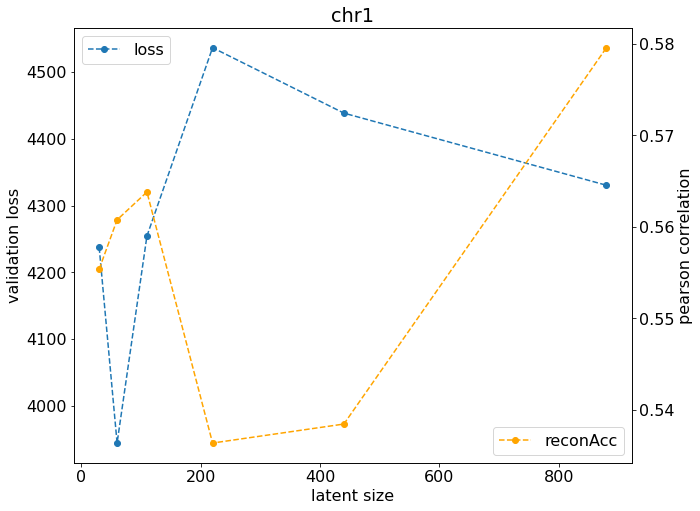

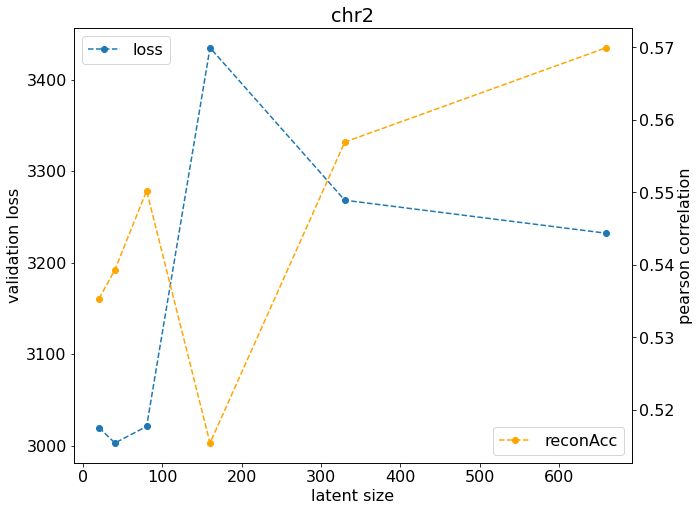

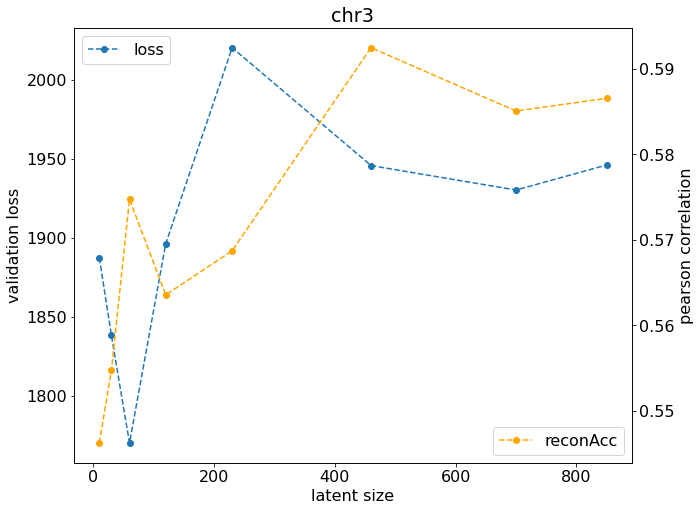

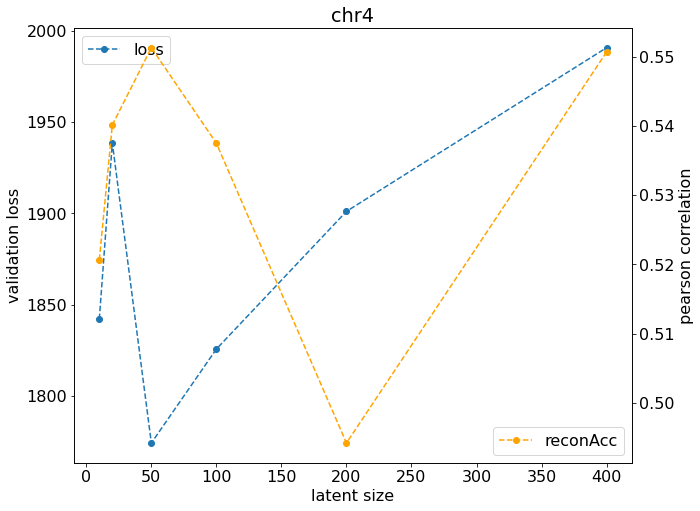

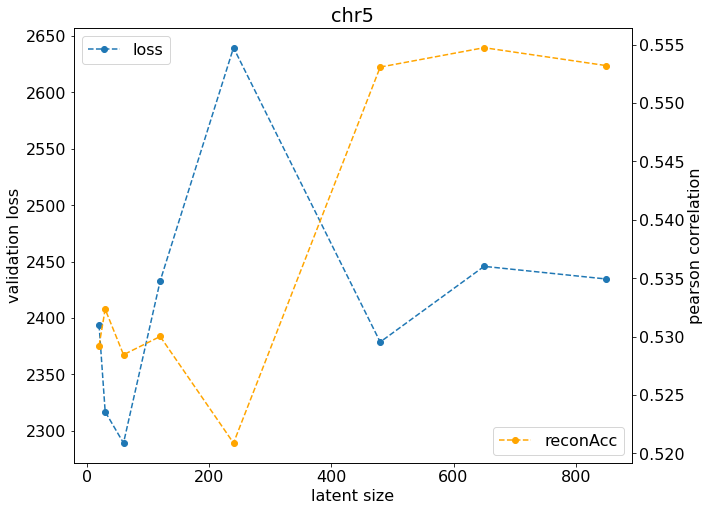

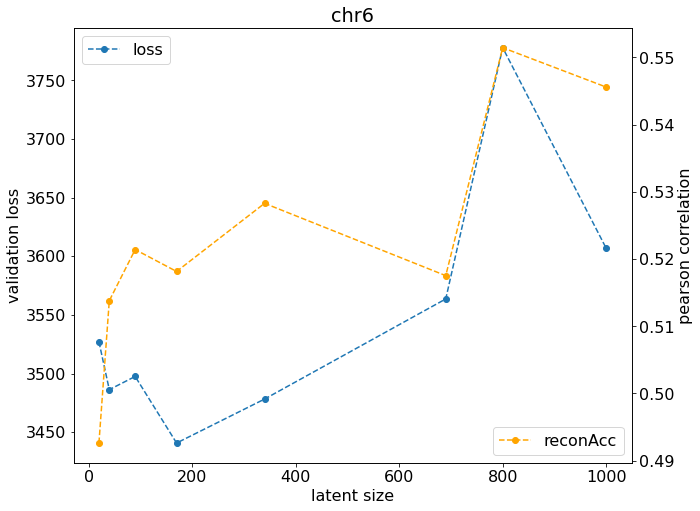

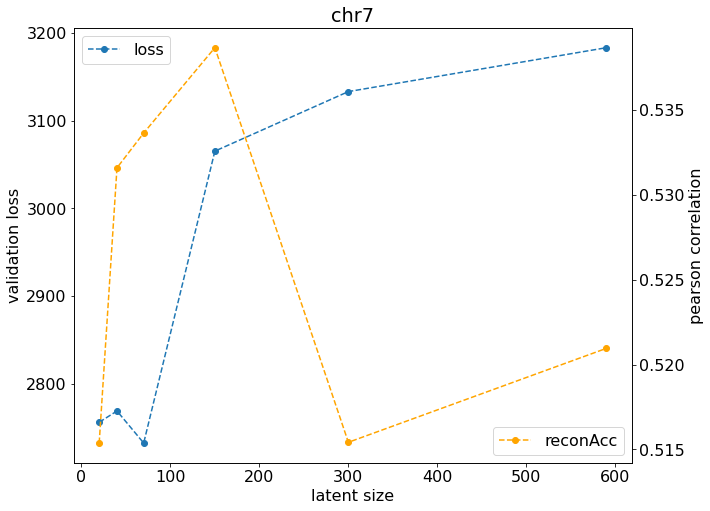

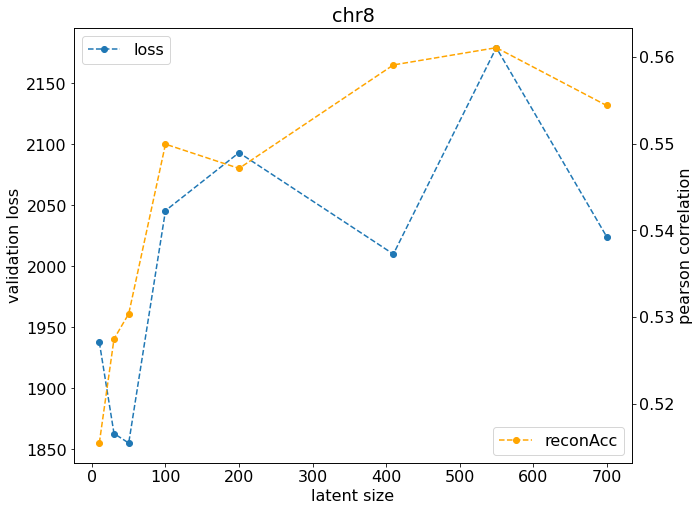

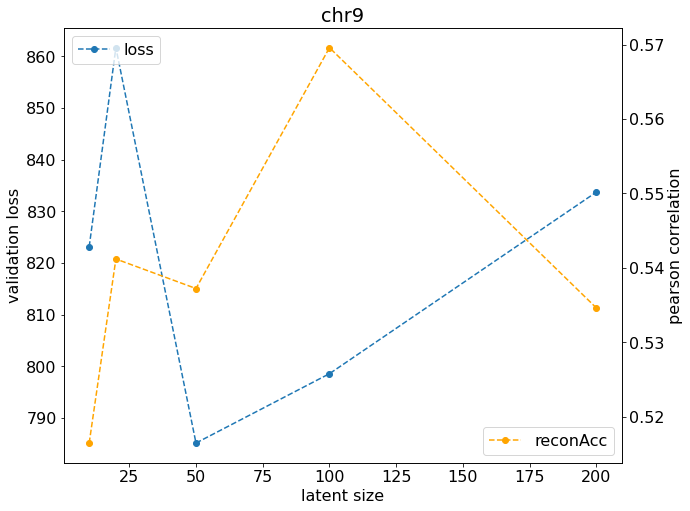

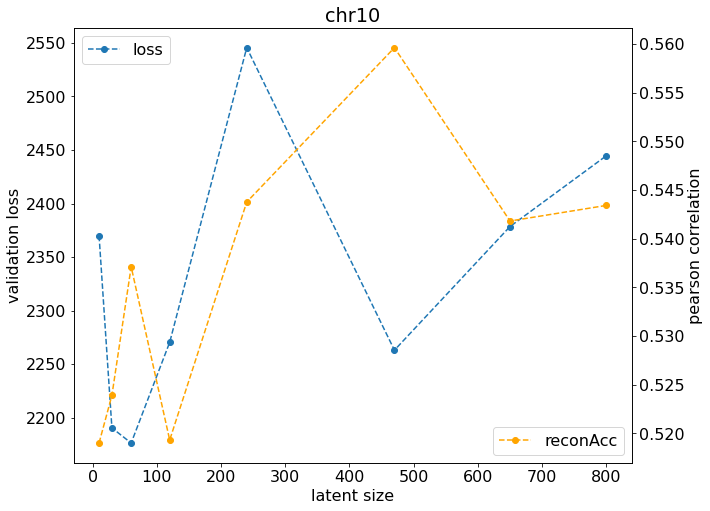

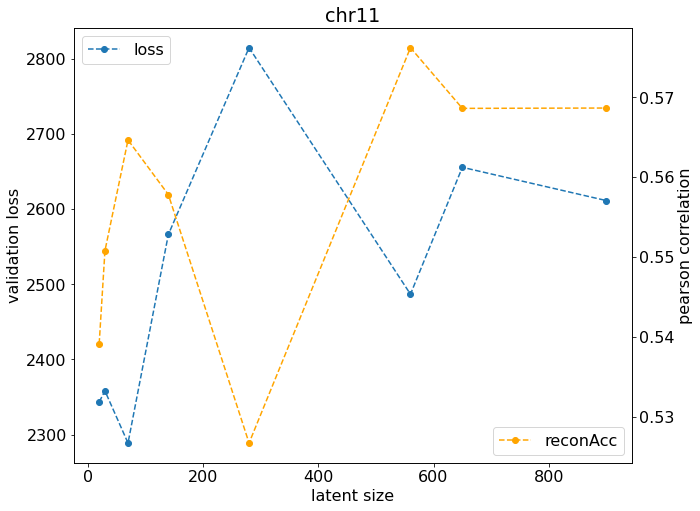

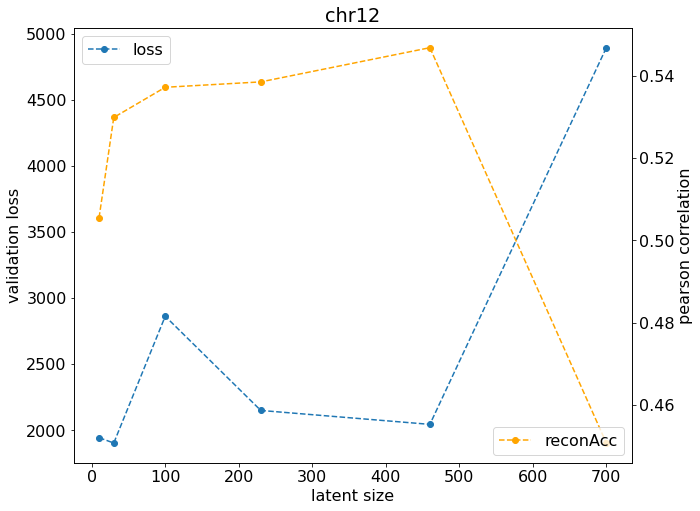

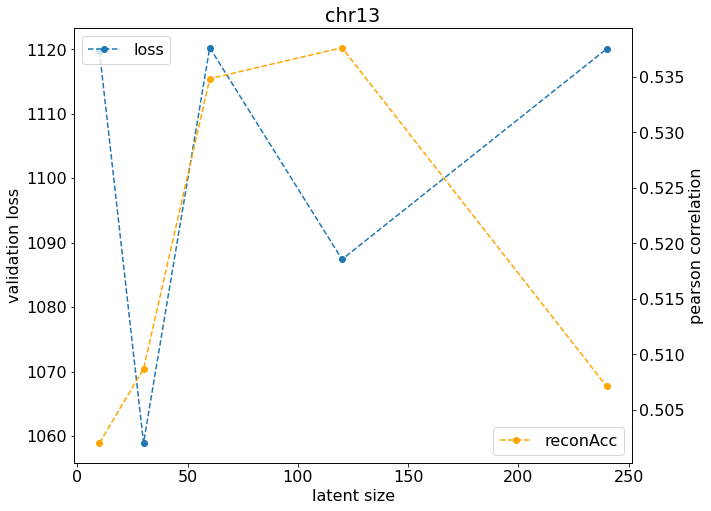

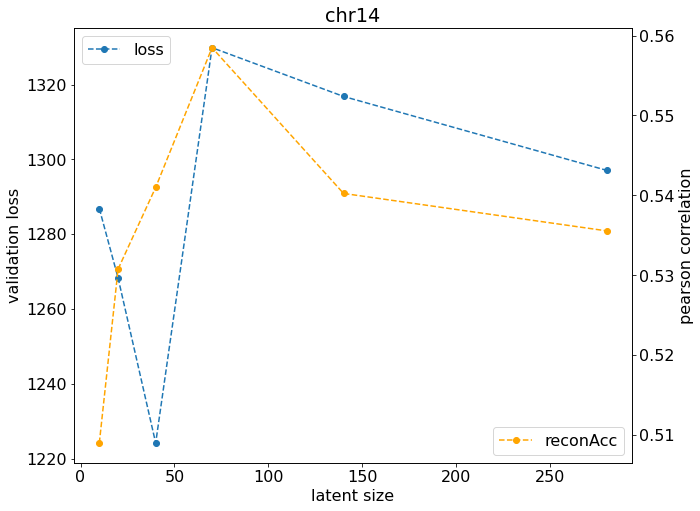

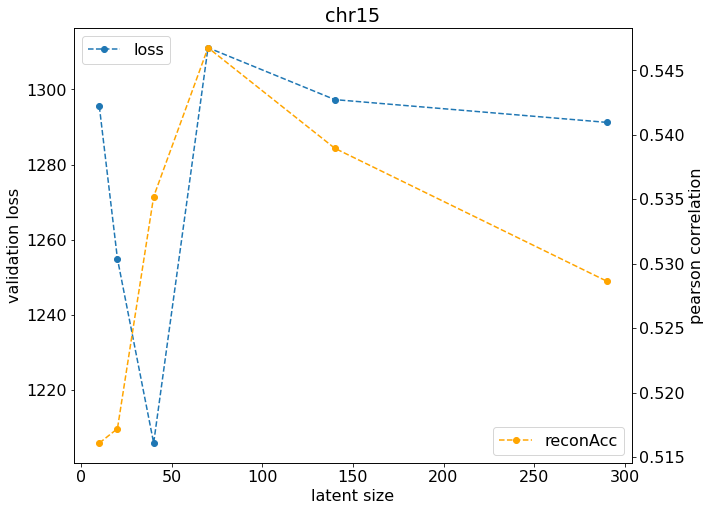

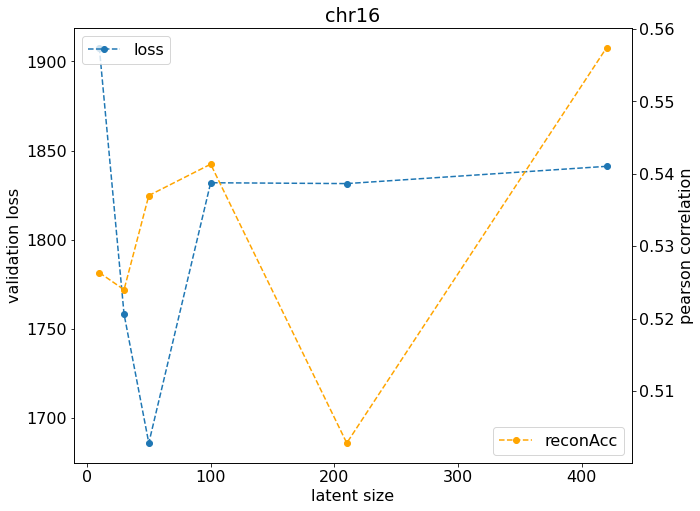

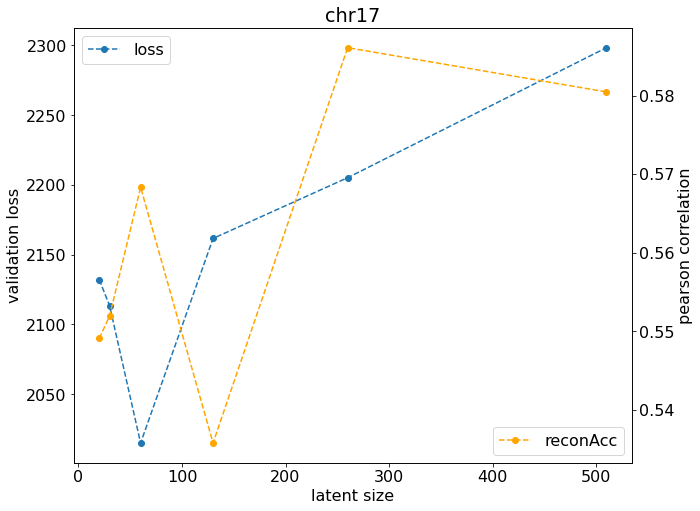

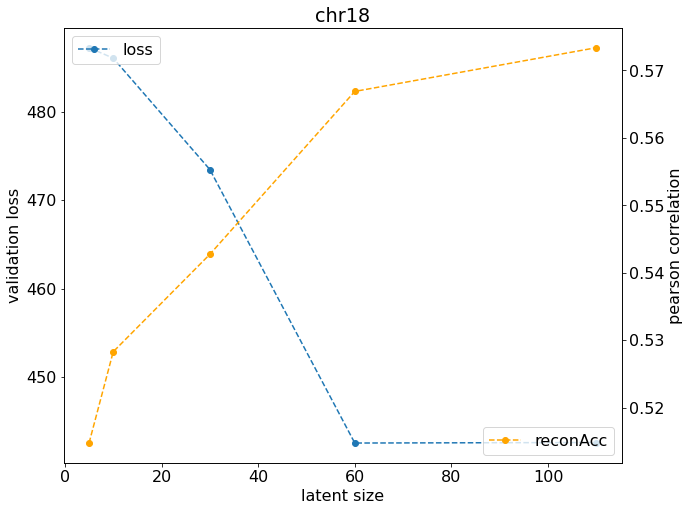

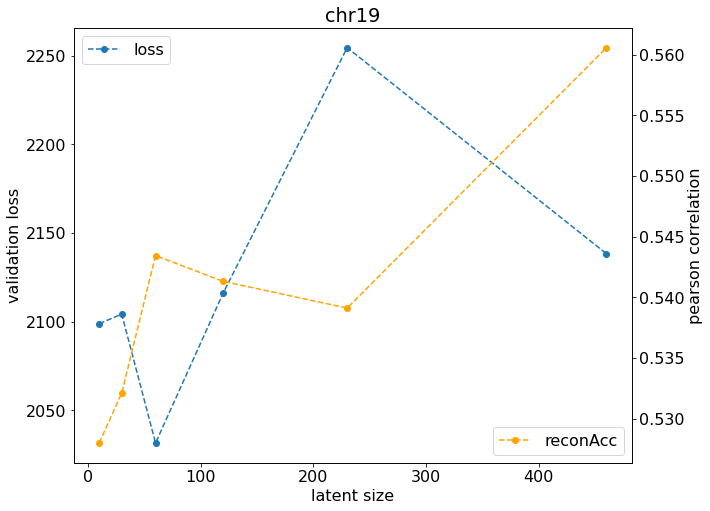

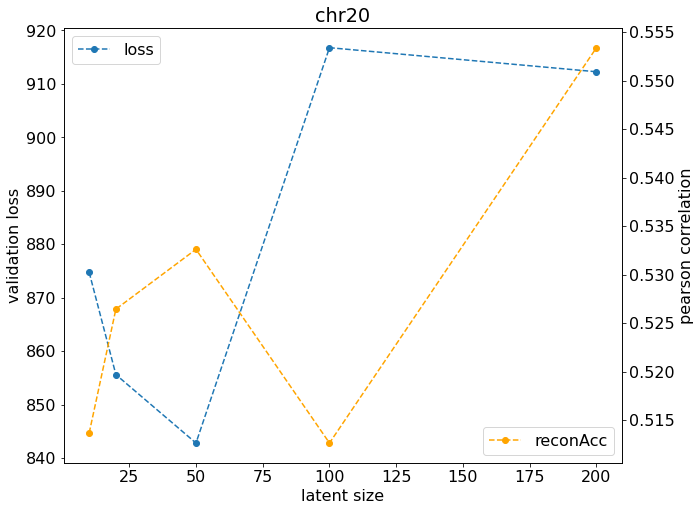

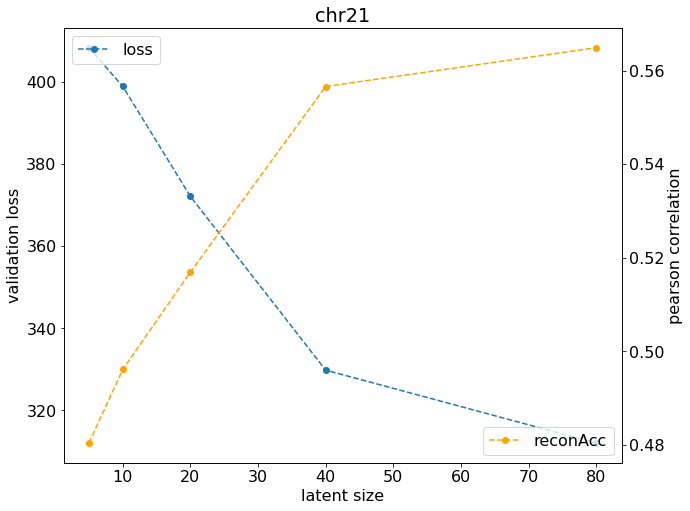

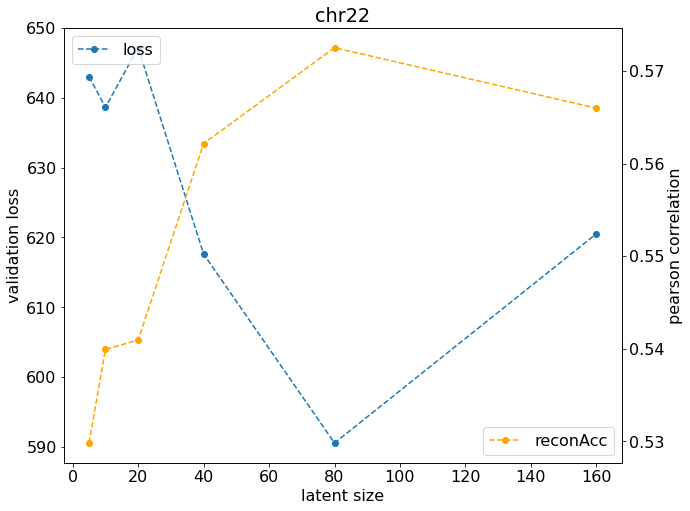

In [17]:
#CHR = "chr8"
PATH_figures = "figures/latSizeOptimisation_coarse/"
for CHR in [f"chr{i}" for i in range(1,23)]:
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    df_summary = pd.read_csv(f"{PATH_results}/scoring+ranking.csv")
    LATSIZES = np.sort(df_summary["latSize"].unique())

    latSizes_loss = [df_summary[df_summary["latSize"] == LATSIZE].iloc[0,5] for LATSIZE in LATSIZES]
    latSizes_pearson = [df_summary[df_summary["latSize"] == LATSIZE].iloc[0,4] for LATSIZE in LATSIZES]

    print(LATSIZES)

    fig, ax = plt.subplots(figsize=(10,8))
    fig.patch.set_alpha(1)
    ax.plot(LATSIZES, latSizes_loss, '--o', label="loss")
    ax.set_ylabel("validation loss")
    ax2 = ax.twinx()
    ax2.plot(LATSIZES, latSizes_pearson, "--o",c="orange", label="reconAcc")
    ax2.set_ylabel("pearson correlation")
    ax.set_xlabel("latent size")
    ax.set_title(f"{CHR}")
    ax2.legend(loc=4)
    ax.legend(loc=2)
    fig.savefig(f"{PATH_figures}/{CHR}.png")

## Manual selection and save:

In [15]:
### Determine best model 
print(CHR+"\n")
BEST_LAT = 100
df_best = df_summary[df_summary["latSize"] == BEST_LAT].iloc[0,]
print(df_best)

### save in file 
dict_bestLat = {}
dict_bestLat["chr"] = df_best["chr"]
dict_bestLat["latSize"] = str(df_best["latSize"])
dict_bestLat["lr"] = df_best["lr"]
dict_bestLat["dropr"] = df_best["dropr"]

PATH_results = f"logs/optimisation/{CHR}/coarse"
with open(f"{PATH_results}/best_model_coarseOptimization.json", "w") as f: json.dump(dict_bestLat, f, indent=4)
print("\n\nSaved!")

chr8

chr                    chr8
latSize                 100
lr                   0.0005
dropr                   0.1
pearson_mean       0.549938
loss_mean       2045.616101
idx_pearson               1
idx_loss                  3
idx_mean                2.0
Name: 24, dtype: object


Saved!


## Remove all (but best model) .pth files of coarse grained search
to save some space on the cluster

In [28]:
delete_sure = False

print(CHR)

chr11


In [109]:
if delete_sure:
    ### Get best model
    print(PATH_results)
    with open(f"{PATH_results}/best_model_coarseOptimization.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latSize"]
    lr = dict_bestModel["lr"]
    dropr = dict_bestModel["dropr"]    
    name = f"latSize_{latSize}_lr_{lr}_dropr_{dropr}"
    print(name)
    
    ### Deleete all .pth but best model
    for folder in os.listdir(PATH_results):
        if folder.startswith("latSize_"):
            if folder.startswith(name):
                print(folder)
                print("Spared best model")
            else:
                try:
                    os.remove(f"{PATH_results}/{folder}/checkpoint/trainedModel.pth")
                except FileNotFoundError:
                    continue

logs/optimisation/chr21/coarse
latSize_40_lr_0.0005_dropr_0.1
latSize_40_lr_0.0005_dropr_0.1
Spared best model


# Sanity check: Chr22 now & before

In [ ]:
### compare chr22 with old chr22!! --> wiht old HP same results?

In [40]:
for CHR in ["chr22"]: #["chr20"]:   
    df_summary = pd.DataFrame()
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(f"{PATH_results}/param_grid_coarse.json", "r") as f: LATSIZES = json.load(f)["latentSize_coarse"]
    for LATSIZE in LATSIZES:
        ### Lod scoring for each latSize
        with open(f"{PATH_results}/scoring_latSize_{LATSIZE}.json", "r") as f: dict_scoring = json.load(f)
        ### Do the ranking over all runs with one latent size
        df_ranking = getRanking(dict_scoring)
        df_summary = pd.concat([df_summary, df_ranking], ignore_index=True)
    df_summary.to_csv(f"{PATH_results}/scoring+ranking.csv", index=False)


|                    | layers   | lr     | dropr | pearson_mean | loss_mean  |   |
|--------------------|----------|--------|-------|--------------|------------|---|
| HP_opt: latSize=20 | 1570,310 | 0.0005 | 0.3   | 0.540938     | 647.171844 |   |
| old: latSize=25    | 2000,500 | 0.0001 | 0.3   | 0.532        | 621.334314 |   |
| HP_opt: latSize=20 | 1570,310 | 0.0001 | 0.3   | 0.516324     | 629.472815 |   |

In [38]:
print(LATSIZES)
df_summary[df_summary["latSize"] == "80"]   ### best 	0.0005	0.3	0.540938	647.171844

[160, 80, 40, 20, 10, 5]


,chr,latSize,lr,dropr,pearson_mean,loss_mean,idx_pearson,idx_loss,idx_mean
12,chr22,80,0.0005,0.3,0.572536,590.569916,1,1,1.0
13,chr22,80,0.0005,0.1,0.56922,621.987152,2,3,2.5
14,chr22,80,0.0005,0.5,0.560358,610.29422,5,2,3.5
15,chr22,80,0.001,0.1,0.560525,667.110992,4,6,5.0
16,chr22,80,0.001,0.5,0.555665,646.614349,6,5,5.5
17,chr22,80,0.001,0.3,0.560709,709.030536,3,9,6.0
18,chr22,80,0.0001,0.1,0.510484,642.674866,9,4,6.5
19,chr22,80,0.005,0.3,0.520312,691.689319,8,8,8.0
20,chr22,80,0.005,0.1,0.544053,769.482849,7,10,8.5
21,chr22,80,0.005,0.5,0.498032,676.088794,11,7,9.0
